# Tutorial for batch processing in `expsolve`

We illustrate this with `expsolve.fourier`, which is imported as `ex`.

Batch processing is built-in in `expsolve` from ground up. This notebook demonstrates how to use it in practice.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

import expsolve as es
import expsolve.discretize.tensorgrid as ex
import expsolve.evolve.splittings.classical as split

import torch
from torch import exp, sin, cos, abs, real, imag, pi
from torch.linalg import matrix_exp

In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
device

device(type='cuda')

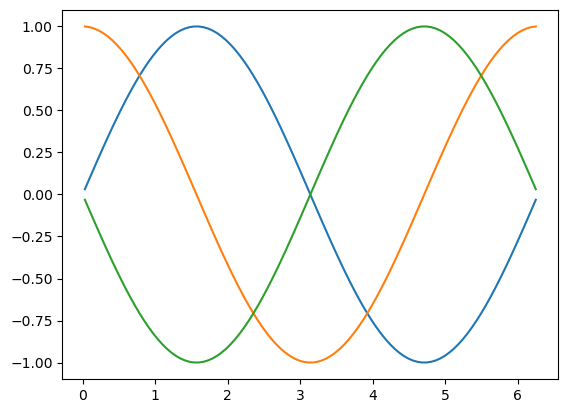

torch.Size([1, 100])
torch.Size([1, 100])


In [3]:
xrange = [0, 2*np.pi]
n = 100
x = ex.grid1d(n, xrange).to(device)     # this ensures everything ends up on the appropriate device!
s = sin(x)
ds = real(ex.diffop(0,1,s,xrange))
d2s = real(ex.diffop(0,2,s,xrange))

ex.plot(plt, x, s)
ex.plot(plt, x, ds)
ex.plot(plt, x, d2s)
plt.show()

print(s.shape)
print(ds.shape)

torch.Size([4, 100])
torch.Size([4, 100])


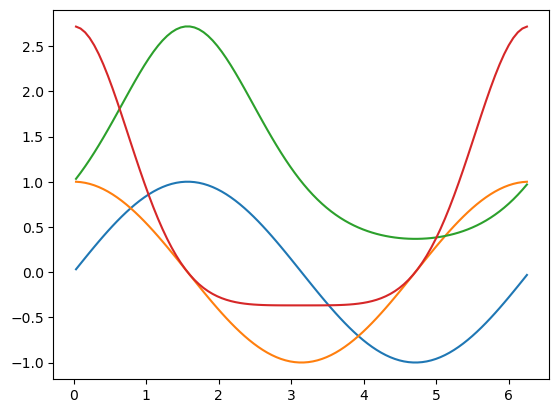

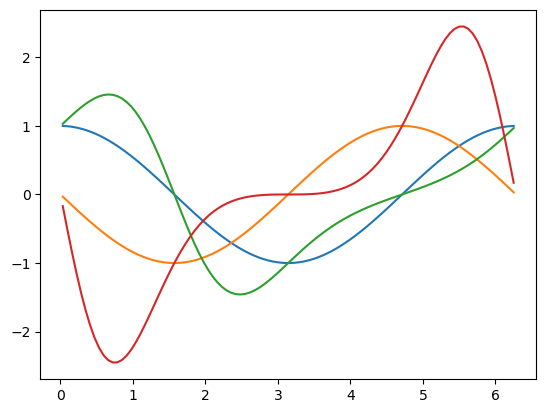

In [5]:
fns = [sin, cos, lambda x: exp(sin(x)), lambda x: cos(x)*exp(cos(x))]
f = torch.stack([f(x).flatten() for f in fns])
print(f.shape)


plt.figure()
ex.plot(plt, x, f, separatelines=True)

df = real(ex.diffop(0,1,f,xrange))
d2f = real(ex.diffop(0,2,f,xrange))
print(df.shape)

plt.figure()
ex.plot(plt, x, df, separatelines=True)
plt.show()

### Randomized functions

torch.Size([3, 100])


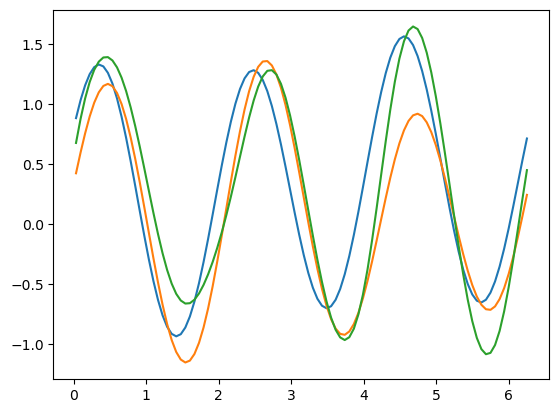

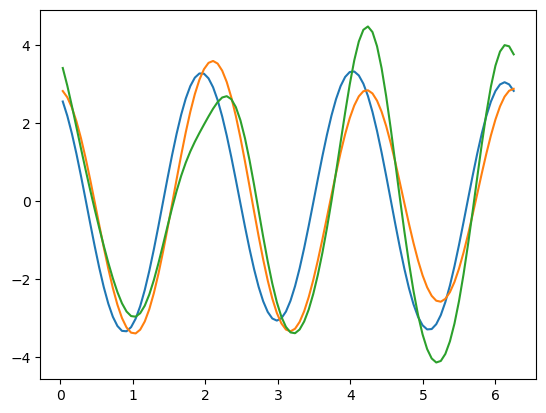

In [8]:
N = 3

# random, periodic functions
def randomf():
    # q real, p int
    p = np.random.randint(low=-5, high=5, size=4)
    q = np.random.normal(loc=0.2, scale=0.1, size=5)
    return sin(3*x) + q[0]*sin(p[0]*x) + q[1]*exp(q[2]*sin(p[1]*x)) + q[3]*cos(p[2]*x)*exp(q[4]*cos(p[3]*x))

fr = torch.stack([randomf().flatten() for _ in range(N)])


plt.figure()
ex.plot(plt, x, fr, separatelines=True)
dfr = real(ex.diffop(0,1,fr,xrange))
print(dfr.shape)

plt.figure()
ex.plot(plt, x, dfr, separatelines=True)
plt.show()


### Advantage of batch parallelization

In [9]:
N = 10000
frlist = [randomf() for _ in range(N)]
frtensor = torch.stack([fr.flatten() for fr in frlist])

tim1 = time.time()
dfrtensor = real(ex.diffop(0,1,frtensor,xrange))
tim2 = time.time()
tim_batch = tim2-tim1
print(f'Batch of size {N} took {tim_batch}s')


tim1 = time.time()
for fr in frlist:
    dfr = real(ex.diffop(0,1,fr,xrange))
tim2 = time.time()
tim_loop = tim2-tim1
print(f'Loop of size {N} took {tim_loop}s')

print(f'Speed up factor {tim_loop/tim_batch:.2f} on {device}')


Batch of size 10000 took 0.0067141056060791016s
Loop of size 10000 took 6.770699501037598s
Speed up factor 1008.43 on cuda


## Batch visualization

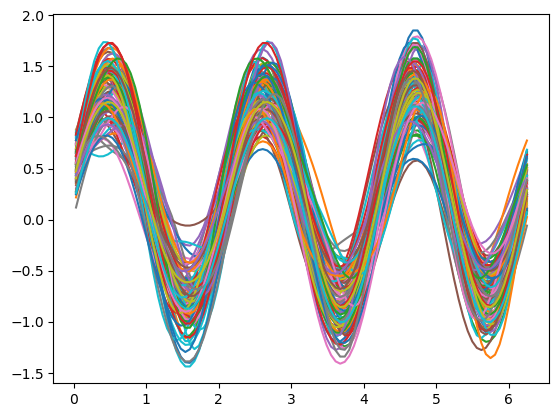

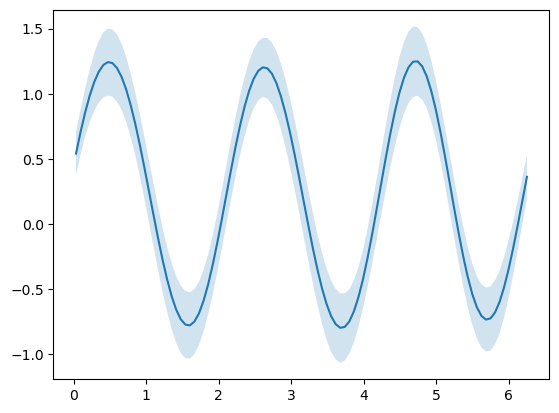

In [10]:
N = 100
frlist = [randomf() for _ in range(N)]
frtensor = torch.stack([fr.flatten() for fr in frlist]) 

plt.figure()
ex.plot(plt, x, frtensor, separatelines=True)
plt.show()

plt.figure()
ex.plot(plt, x, frtensor)
plt.show()

## Solving the Schrodinger equation, when initial conditions are in a batch

### Creating and visualizing a random batch of initial conditions

In [11]:
n = 200
L = 10
xr = [-L, L]
x = ex.grid1d(n, xr).to(device)

V = x**4 - 10*x**2

def ugen(sx0, svar, sw0):
    x0 = np.random.normal(loc=0, scale=sx0)
    var = 0.1 + np.random.normal(loc=0, scale=svar)**2
    w0 = np.random.normal(loc=0, scale=sw0)

    u = exp(-(x-x0)**2/(2*var))*exp(1j*pi*w0*(x-x0))    
    u = ex.normalize(u, xr)
    return u


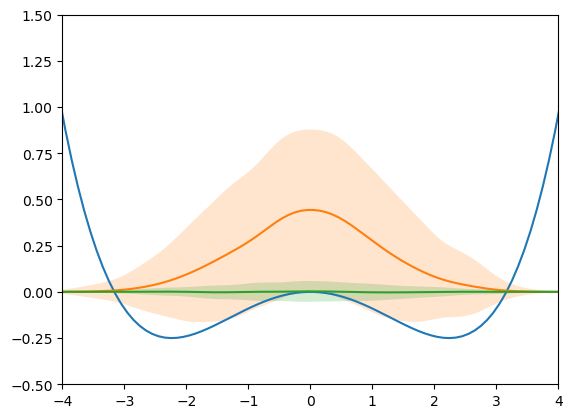

In [12]:
N = 1000
urlist = [ugen(sx0=1.0, svar=0.3, sw0=0.1) for _ in range(N)]
urtensor = torch.stack([ur.flatten() for ur in urlist]) 

ex.plot(plt, x, V/100)
ex.plot(plt, x, real(urtensor))
ex.plot(plt, x, imag(urtensor))
plt.xlim([-4,4])
plt.ylim([-0.5,1.5])
plt.show()

Verifying that all initial conditions have norm 1.

Demonstrating l2norm on a batch

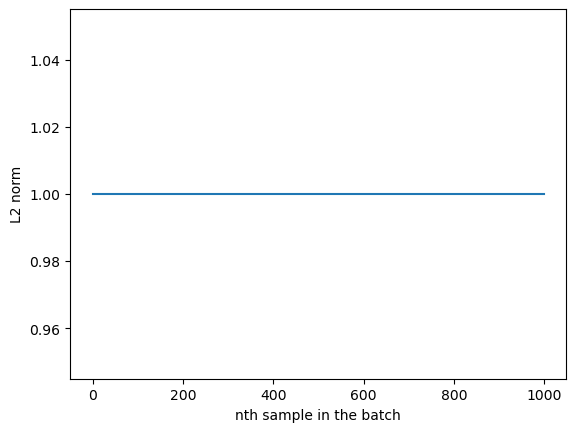

In [13]:
plt.plot(ex.l2norm(urtensor, xr).cpu())
plt.ylabel('L2 norm')
plt.xlabel('nth sample in the batch')
plt.show()

In [14]:
#v = V.to(device)
eLu = lambda t, tauV, h, c, u: ex.diffopexp(0, 2, 1j*c*h, u, xr)
eVu = lambda t, tauL, h, c, u: exp(-1j*c*h*V)*u

strangalpha, strangbeta = split.symmetric([],[])
print(strangalpha, strangbeta)

strangstep = lambda t, h, u0: split.stepper(t, h, u0, eVu, eLu, strangalpha, strangbeta)

tensor([0.5000, 0.5000], dtype=torch.float64) tensor([1., 0.], dtype=torch.float64)


In [15]:
T = 1.

tim1 = time.time()
uTbatch = es.solvediffeq(urtensor, es.timegrid(T, 10), strangstep)[0]
tim2 = time.time()
tim_batch = tim2-tim1
print(f'Batch of size {N} took {tim_batch}s')


tim1 = time.time()
for ur in urlist:
    ustrangTloop = es.solvediffeq(ur, es.timegrid(T, 10), strangstep)[0]
tim2 = time.time()
tim_loop = tim2-tim1
print(f'Loop of size {N} took {tim_loop}s')

print(f'Speed up factor {tim_loop/tim_batch:.2f} on {device}')

Batch of size 1000 took 0.15151524543762207s
Loop of size 1000 took 11.54741358757019s
Speed up factor 76.21 on cuda


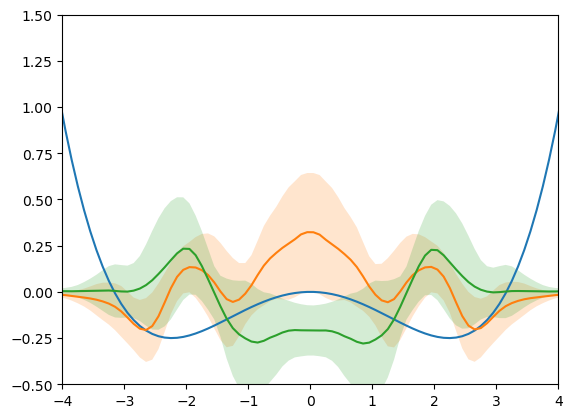

In [16]:
ex.plot(plt, x, V/100)
ex.plot(plt, x, real(uTbatch))
ex.plot(plt, x, imag(uTbatch))
plt.xlim([-4,4])
plt.ylim([-0.5,1.5])
plt.show()

### Observables

In [17]:
Nstep = 100
timegrid = es.timegrid(T, Nstep)

observables = {'energy': lambda u: ex.observable(lambda psi: -ex.diffop(0, 2, psi, xr) + V*psi, u, xr), 
'position': lambda u: ex.observable(lambda psi: x*psi, u, xr), 
'momentum': lambda u: ex.observable(lambda psi: 1j*ex.diffop(0, 1, psi, xr), u, xr), 
'kinetic': lambda u: ex.observable(lambda psi: -ex.diffop(0, 2, psi, xr), u, xr), 
'potential':lambda u: ex.observable(lambda psi: V*psi, u, xr)}

uTbatch, obsvalues_batch, uintermediate_batch = es.solvediffeq(urtensor, timegrid, strangstep, observables=observables)

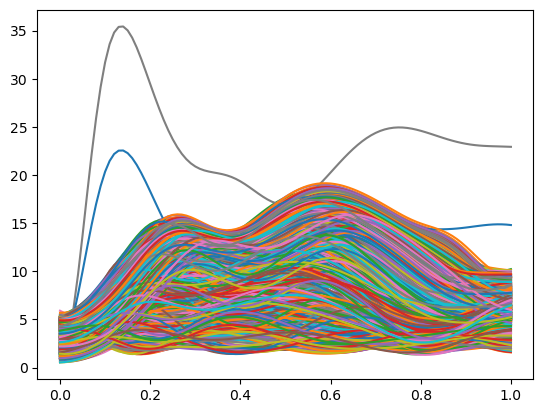

In [19]:
ex.plot(plt, timegrid, obsvalues_batch['kinetic'], separatelines=True)

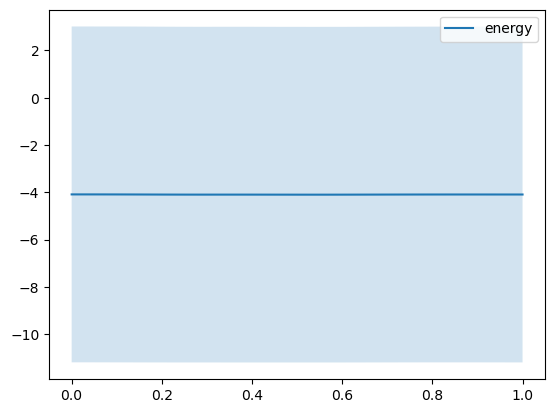

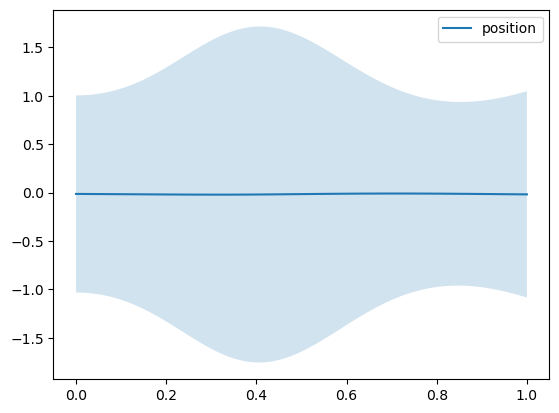

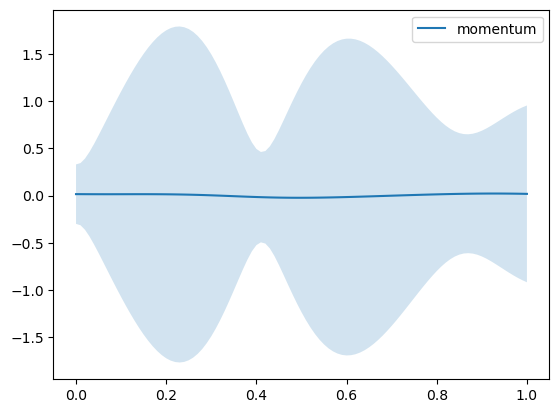

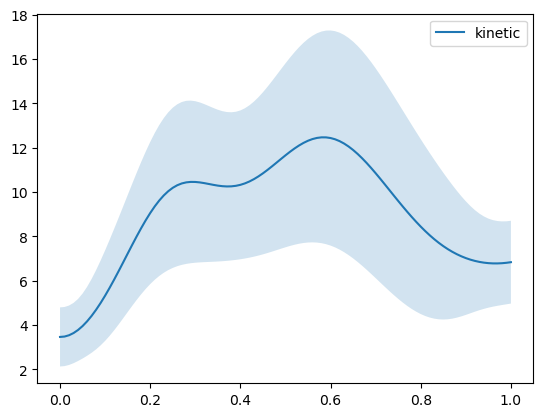

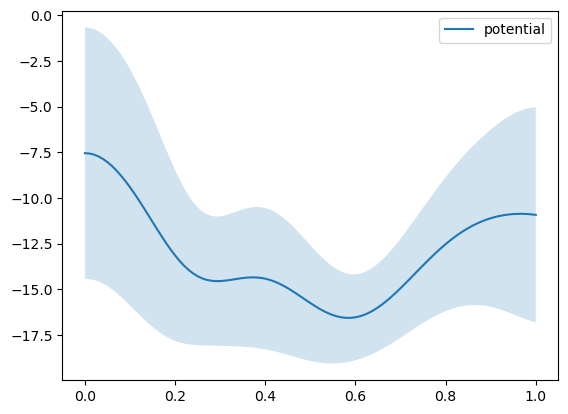

In [20]:
for o in observables:
    ov = obsvalues_batch[o]
    plt.figure()
    ex.plot(plt, timegrid, ov)   
    plt.legend([o])
    plt.show()

### Computing matrix vector products - for brute force solution, for example

In [17]:
N = 1000
urlist = [ugen(sx0=1.0, svar=0.3, sw0=0.1) for _ in range(N)]
urtensor = torch.stack([ur.flatten() for ur in urlist]) 

D2 = ex.diffmatrix(2, n, xr).to(device)
H = -D2 + es.linalg.diag(V)

In [18]:
print(H.shape)
print(urtensor.shape)
print(es.linalg.matmul(H, urtensor).shape)

torch.Size([200, 200])
torch.Size([1000, 200])
torch.Size([1000, 200])


In [19]:
T = 1.

tim1 = time.time()
uTexpbatch = es.linalg.matmul(matrix_exp(-1j*T*H), urtensor)  
tim2 = time.time()
tim_batch = tim2-tim1
print(f'Batch of size {N} took {tim_batch}s')


tim1 = time.time()
for ur in urlist:
    uTexploop = es.linalg.matmul(matrix_exp(-1j*T*H), ur)  
tim2 = time.time()
tim_loop = tim2-tim1
print(f'Loop of size {N} took {tim_loop}s')

print(f'Speed up factor {tim_loop/tim_batch:.2f} on {device}')

Batch of size 1000 took 0.017004013061523438s
Loop of size 1000 took 12.793421506881714s
Speed up factor 752.38 on cpu


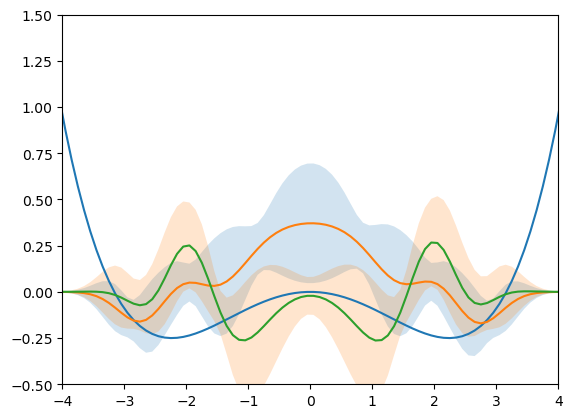

In [20]:
ex.plot(plt, x, V/100)
ex.plot(plt, x, real(uTexpbatch))
ex.plot(plt, x, imag(uTexpbatch))
plt.xlim([-4,4])
plt.ylim([-0.5,1.5])
plt.show()

### 2D example

We *need* to test this too!

In [21]:
n = [50, 50]
xr = [-10, 10]
[x,y] = ex.grid(n, xr)

V = x**4 + y**4 - 5*x**2 - 5*y**2

def ugen2D(sx0, svar, sw0):
    x0 = np.random.normal(loc=0, scale=sx0)
    y0 = np.random.normal(loc=0, scale=sx0)
    var = 0.1 + np.random.normal(loc=0, scale=svar)**2
    w0x = np.random.normal(loc=0, scale=sw0)
    w0y = np.random.normal(loc=0, scale=sw0)

    u = exp(-((x-x0)**2 + (y-y0)**2)/(2*var)) * exp(1j*pi*w0x*(x-x0)) * exp(1j*pi*w0y*(y-y0))    
    u = ex.normalize(u, xr)
    return u

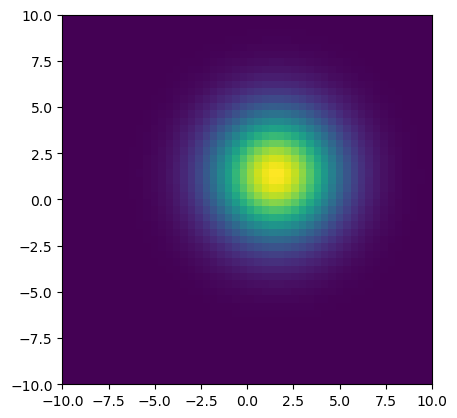

In [22]:
u = ugen2D(sx0=3.0, svar=2.0, sw0=1.0)
ex.imshow(plt, xr, abs(u))
plt.show()

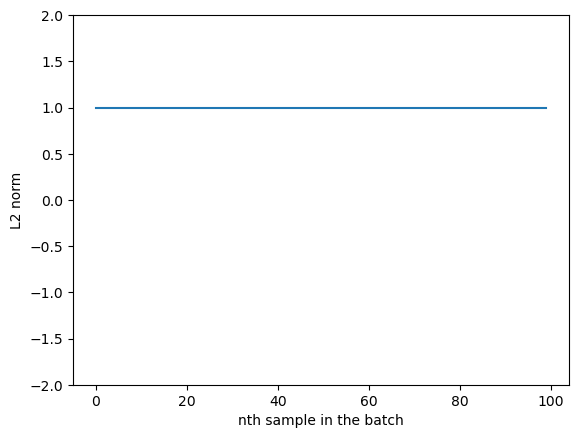

In [23]:
N = 100
urlist = [ugen2D(sx0=3.0, svar=2.0, sw0=1.0).squeeze(dim=0) for _ in range(N)]
urtensor = torch.stack(urlist) 

plt.plot(ex.l2norm(urtensor, xr).cpu())
plt.ylabel('L2 norm')
plt.xlabel('nth sample in the batch')
plt.ylim([-2,2])
plt.show()

In [24]:
#v = V.to(device)
eL1u = lambda h, c, u: ex.diffopexp(0, 2, 1j*h, u, xr) 
eL2u = lambda h, c, u: ex.diffopexp(1, 2, 1j*h, u, xr)

eLu = lambda t, tauV, h, c, u: eL1u(h, c, eL2u(h, c, u)) 
eVu = lambda t, tauL, h, c, u: exp(-1j*c*h*V)*u

strangalpha, strangbeta = split.symmetric([],[])
print(strangalpha, strangbeta)

strangstep = lambda t, h, u0: split.stepper(t, h, u0, eVu, eLu, strangalpha, strangbeta)

tensor([0.5000, 0.5000], dtype=torch.float64) tensor([1., 0.], dtype=torch.float64)


In [25]:
Nstep = 200
timegrid = es.timegrid(T, Nstep)

observables = {'energy': lambda u: ex.observable(lambda psi: -ex.diffop(0, 2, psi, xr) -ex.diffop(1, 2, psi, xr) + V*psi, u, xr), 
'position x': lambda u: ex.observable(lambda psi: x*psi, u, xr), 
'position y': lambda u: ex.observable(lambda psi: y*psi, u, xr), 
'momentum x': lambda u: ex.observable(lambda psi: 1j*ex.diffop(0, 1, psi, xr), u, xr), 
'momentum y': lambda u: ex.observable(lambda psi: 1j*ex.diffop(1, 1, psi, xr), u, xr), 
'kinetic': lambda u: ex.observable(lambda psi: -ex.diffop(0, 2, psi, xr) -ex.diffop(1, 2, psi, xr), u, xr), 
'potential':lambda u: ex.observable(lambda psi: V*psi, u, xr)}

In [26]:
T = 1.

tim1 = time.time()
uTbatch, obsvalues_batch, uintermediate_batch = es.solvediffeq(urtensor, timegrid, strangstep, observables=observables)
tim2 = time.time()
tim_batch = tim2-tim1
print(f'Batch of size {N} took {tim_batch}s')


tim1 = time.time()
for ur in urlist:
    ustrangTloop = es.solvediffeq(ur.unsqueeze(dim=0), timegrid, strangstep, observables=observables)[0]
tim2 = time.time()
tim_loop = tim2-tim1
print(f'Loop of size {N} took {tim_loop}s')

print(f'Speed up factor {tim_loop/tim_batch:.2f} on {device}')

Batch of size 100 took 15.082503080368042s
Loop of size 100 took 87.9662697315216s
Speed up factor 5.83 on cpu


Speedup is expected to be more when each problem itself is small, and the number of batches large. For high dimensional problems, this reduces the speedup from batch operations. The exact level at which speedup becomes limited depends on the CPU/GPU architecture heavily, of course.

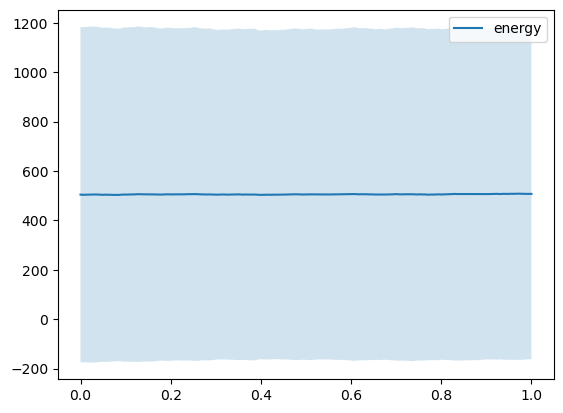

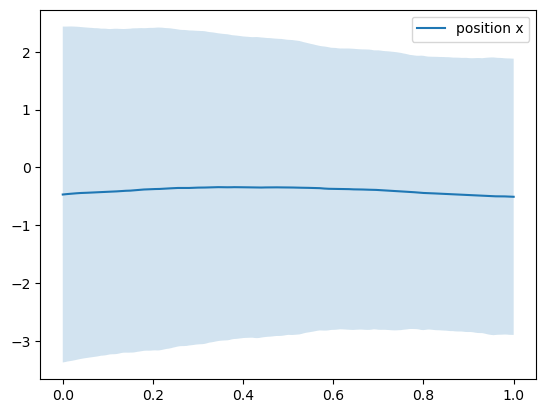

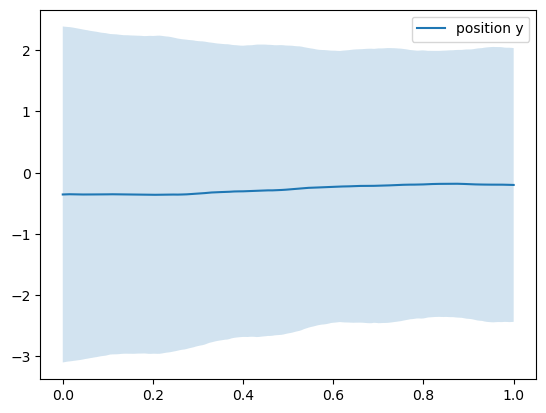

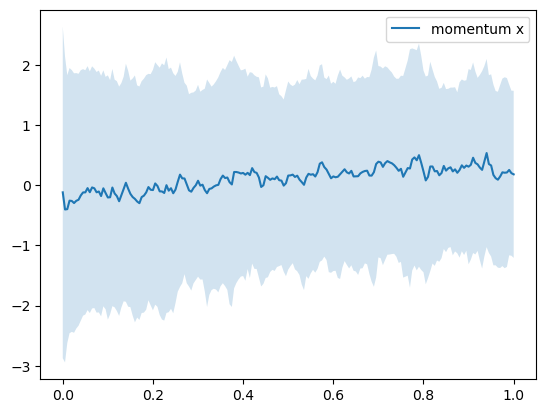

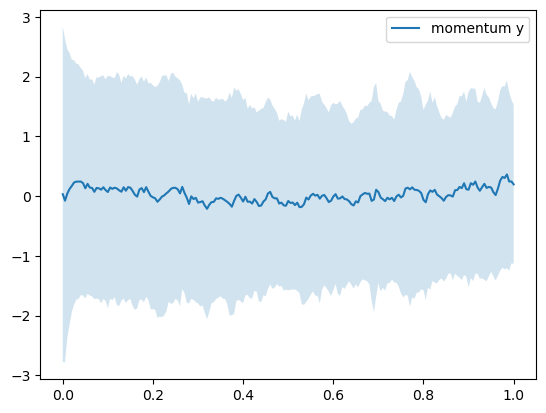

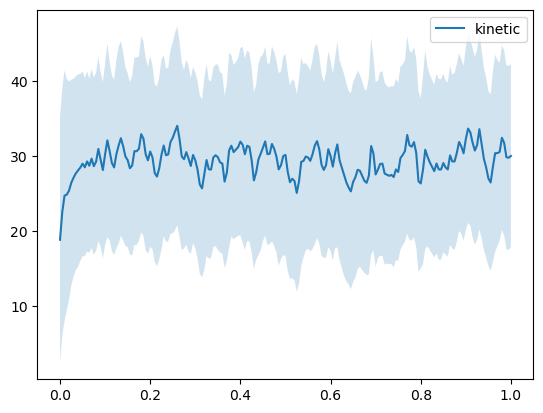

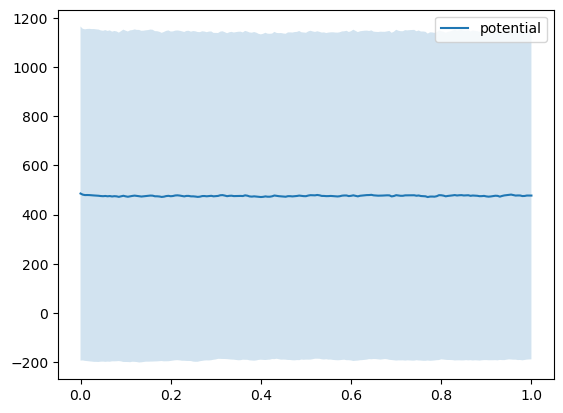

In [27]:
for o in observables:
    ov = obsvalues_batch[o]
    plt.figure()
    ex.plot(plt, timegrid, ov)   
    plt.legend([o])
    plt.show()

## Solving the Schrodinger equation, when propagator is in a batch

Randomize potentials. Use random potentials for potential and total energy.